# PROJECT 4: Analysis of Marathon Results with Kernel Density Estimate and Bayes Theorem
# Van Le
# ID: 5036 1991
# MTH 448
# May 14, 2023

# 1. Introduction:

The analysis of marathon data provides valuable insights into the performance and characteristics of runners in one of the most iconic long-distance running events. We delve into the marathon data to uncover interesting patterns and relationships among various factors. We can gain a deeper understanding of the factors influencing marathon performance and make accurate predictions about runner characteristics by using Kernel Density Estimates and Bayes Theorem. In this project, we focus on the following key reasons for utilizing KDE 1-dimension and 2-dimension and also make comparision to K-nearest neighbors. The notebook discovers these questions:


1. Gender-based Analysis: We compute a 1-dimensional Kernel Density Estimate (KDE) for male and female runners using their finish times. By applying the Bayes theorem, we determine the probability that a runner with a given finish time is female. 

2. Age and Finish Time Relationship: we extend the KDE approach to a 2-dimensional setting, we explore the joint distribution of finish times and ages.

3. Comparing Predictive Models: In order to assess the effectiveness of our KDE-based predictions, we compare them with predictions derived from the k-Nearest Neighbors (k-NN) algorithm. By using the same input data, we evaluate the accuracy of predictions obtained from both approaches, providing insights into the relative performance of these models.

4. Linear Regression and Predictive Power: Next, we compute linear regression to predict finish times based on the 5K times of runners. Further exploration of extra features to see if the predictive model is significant improve.

**Import** **libraries**

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm, gaussian_kde
from datetime import datetime
from ipywidgets import interact, fixed, FloatSlider
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, mean_squared_error, r2_score, classification_report


# 2. Dataset:

`csv` file which contains race results of about 26,000 marathon runners: `marathon_results.csv`.
This dataset contains information about the runners age, gender, nationality, split times, finishing time, pace, rankings, and divisions of the runners in a marathon race. It provides detail into the performance and characteristics of the participants in terms of length of run. 

In [2]:
df = pd.read_csv("marathon_results.csv")
df.sample(5)

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division
21152,45,M,USA,00:33:05,01:01:31,01:29:43,01:58:27,02:04:40,02:27:32,02:58:22,03:30:44,04:04:41,04:15:45,00:09:46,21327,12255,2196
15394,35,F,USA,00:24:54,00:49:20,01:15:18,01:40:28,01:45:51,02:05:52,02:33:04,03:02:11,03:33:06,03:46:57,00:08:40,15480,5518,3583
19961,68,M,USA,00:26:57,00:56:11,01:23:34,01:56:37,02:02:58,02:25:37,02:57:35,03:27:45,03:55:08,04:07:22,00:09:27,20111,11787,159
8837,42,M,USA,00:22:30,00:44:27,01:06:58,01:30:24,01:35:40,01:54:52,02:19:52,02:45:03,03:12:48,03:26:17,00:07:53,8861,7051,1307
15858,66,M,CAN,00:28:46,00:54:26,01:20:39,01:46:55,01:52:36,02:13:08,02:40:51,03:09:23,03:36:21,03:48:38,00:08:44,15954,10127,48


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       26298 non-null  int64 
 1   M/F       26298 non-null  object
 2   Country   26298 non-null  object
 3   5K        26298 non-null  object
 4   10K       26298 non-null  object
 5   15K       26298 non-null  object
 6   20K       26298 non-null  object
 7   Half      26298 non-null  object
 8   25K       26298 non-null  object
 9   30K       26298 non-null  object
 10  35K       26298 non-null  object
 11  40K       26298 non-null  object
 12  Finish    26298 non-null  object
 13  Pace      26298 non-null  object
 14  Overall   26298 non-null  int64 
 15  Gender    26298 non-null  int64 
 16  Division  26298 non-null  int64 
dtypes: int64(4), object(13)
memory usage: 3.4+ MB


## 2.1. Data Preprocessing

In [4]:
# Calculates the total minutes it took for each runner to finish the marathon race 
df['Total_minutes'] = pd.to_timedelta(df['Finish']).dt.total_seconds()/60

Text(0.5, 1.0, 'Figure 1. Finish time in minutes')

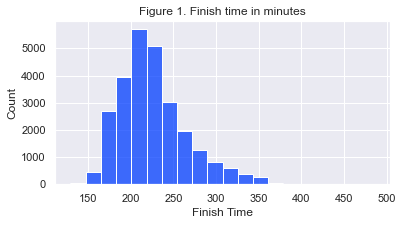

In [5]:
# Plot histogram
plt.figure(figsize=(6, 3))
sns.set_theme(style="darkgrid", palette="bright")
sns.histplot(df['Total_minutes'], bins=20)
plt.xlabel("Finish Time")
plt.title("Figure 1. Finish time in minutes")

The figure 1 shows the distribution of finish times in minutes. The histogram is divided into 20 bins which demonstrate the spread of finish times across 20 different finish time ranges. The majority total time to finish is likely to be more than 200 minutes.

Text(0.5, 1.0, 'Figure 2. Finish time in minutes')

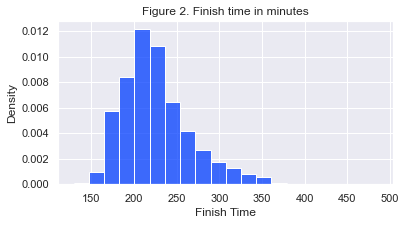

In [6]:
# Plot density plot
np.histogram(df['Total_minutes'], bins=20) 
plt.figure(figsize=(6, 3))
sns.set_theme(style="darkgrid", palette="bright")
sns.histplot(df['Total_minutes'], bins=20, stat="density")
plt.xlabel("Finish Time")
plt.title("Figure 2. Finish time in minutes")

In figure 2, the density distribution of finish times in minutes, and it seems like normal distribution.

## 2.2. Data Splitting

Let's split our dataset into trainig data, validate data and test data. 70% of data is for `train_df`, 30% is equally divided into `valid_df` and `test_df`.

In [7]:
train_df, test_df = train_test_split(df, test_size=.5, random_state=123)
valid_df, test_df = train_test_split(test_df, test_size=.5, random_state=123)

Filtering the data based on `Gender`

In [8]:
# Filter the whole dataset based on gender
dfm = df[df['M/F']=='M']
dff = df[df['M/F']=='F']
# Train set for male and female
dfm_train = train_df[train_df['M/F'] == 'M']
dff_train = train_df[train_df['M/F'] == 'F']
# Test set for male and female
dfm_test = test_df[test_df['M/F'] == 'M']
dff_test = test_df[test_df['M/F'] == 'F']
# Valid set for male and female
dfm_valid = valid_df[valid_df['M/F'] == 'M']
dff_valid = valid_df[valid_df['M/F'] == 'F']

# 3. Kernel Density Estimation:

In statistics, kernel density estimation (KDE) is the application of kernel smoothing for probabiliy density estimation. KDE answers a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. 

## 3.1. KDE for 1-dimension

### 3.1.1. Algorithms

KDE model is a non-paramtric method used to estimate the probability density function of a random variable. . It is using a smooth peak function called kernel to fit the observed data points, thereby simulating the true probability distribution curve. In 1-dimensional dataset `Total_minutes`, the KDE model provides an estimation of the underlying probability distribution that generated the observed data. 
* $K$ is kernel function and $h$ is a smoothing parameter, called bandwidth or window. 

* Kernel function is selected, which determines the shape of the probability distribution around each data point. Common kernel functions include Gaussian (normal) distribution, Epanechnikov or triangular distribution. We will use Gaussian kernel function on our KDE models. For each data point, a kernel fucntion is centered at that point, and the contributions of all kernel funciton are summed to obtain the estimated density at that point [1]

* Bandwidth parameter controls the width of the kernel function. 

### 3.1.2. Model Development

In [9]:
def kde(data, h, x):
    """
    Compute KDE of data with Gaussian kernels

    x:
       KDE value will be computed for each value of this array.
    h:
       Kernel bandwidth
    """

    y = np.zeros_like(x)
    for X in data:
        y += norm.pdf(x, loc=X, scale=h) # sum up all normal distributions
    return y/len(data)


def plot_kde(data, h=0.1, show_kernels=False):
    """
    Plot KDE

    data:
        An array with data defining KDE.
    h:
        Kernel bandwidth.
    show_kernels:
        Boolean. If true, individual kernels are plotted too.
    """

    x = np.linspace(data.min() - 3, data.max() + 3, 400)
    plt.figure(figsize=(6,3))
    plt.plot(x, kde(data, h, x), lw=7, c='steelblue', alpha=0.4)
    plt.plot(data, [0]*len(data), 'r|', ms=15, mew=2)
    if show_kernels:
        for X in data:
            plt.plot(x, 1/len(data)*norm.pdf(x, loc=X, scale=h), 'r--', lw=0.7)

Create a kernel density estimation (KDE) plot for the 'Total_minutes' feature in the training data

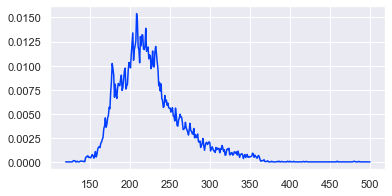

In [10]:
kde = gaussian_kde(train_df['Total_minutes'], bw_method=.01)
plt.figure(figsize=(6, 3))
x = np.linspace(120,500,400)
plt.plot(x, kde(x))

Create a KDE plot for male and female runners with bandwidth = 0.01

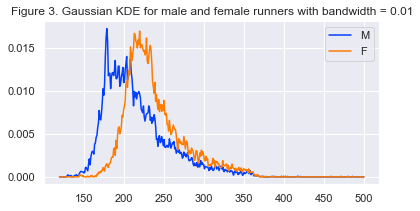

In [11]:
kde_m = gaussian_kde(dfm['Total_minutes'], bw_method=.01)
kde_f = gaussian_kde(dff['Total_minutes'], bw_method=.01)

plt.figure(figsize=(6, 3))
x = np.linspace(120,500,400)
plt.plot(x, kde_m(x),label='M')
plt.plot(x, kde_f(x),label='F')
plt.title("Figure 3. Gaussian KDE for male and female runners with bandwidth = 0.01")
plt.legend()

Create a KDE plot for male and female runners with bandwidth = 0.3

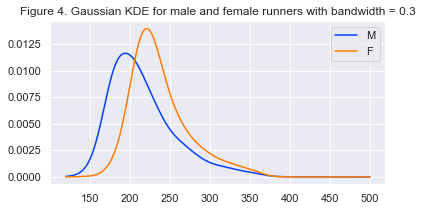

In [12]:
kde_m = gaussian_kde(dfm['Total_minutes'], bw_method=0.3)
kde_f = gaussian_kde(dff['Total_minutes'], bw_method=0.3)

plt.figure(figsize=(6, 3))
x = np.linspace(120,500,400)
plt.plot(x, kde_m(x),label='M')
plt.plot(x, kde_f(x),label='F')
plt.title("Figure 4. Gaussian KDE for male and female runners with bandwidth = 0.3")
plt.legend()

From Figure 3. and 4., higher bandwidth value, smoother the curve of KDE. It's important to choose an appropriate bandwidth value for our data so we'll select the best bandwidth for KDE via cross-validation.

### 3.1.2. Select the bandwidth via Cross-Validation

The bandwidth of the kernel is a free parameter which exhibits a strong influence on the resulting estimate. Too narrow a bandwidth leads to a high-variance estimate (i.e., overfitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., underfitting), where the structure in the data is washed out by the wide kernel [2].
 
* A small $h$ results in a small standard deviation, and the kernel places most of the probability on the data. Use this when the sample size is large and the data are tightly packed [1].
* A large $h$ results in a large standard deviation, and the kernel spreads more of the probability from the data to its neighbouring values. Use this when the sample size is small and the data are sparse. Generally use the size of MISE (Mean Integrated Squared Error) to measure the performance of $h$ [1]. 

We will find the best estimator bandwidth for male KDE and female KDE. Therefore, we calculate the log likelihood fo each value. 

In [13]:
# List of bandwidth values 
bw_choices_m = []
bw_choices_f = []

for bw in np.linspace(0.01, 1, 100):
  # Estimate Gaussian KDE in train set for different bandwidth values 
    kde_m = gaussian_kde(dfm_train['Total_minutes'], bw_method=bw)
    kde_f = gaussian_kde(dff_train['Total_minutes'], bw_method=bw)
  # Calculate the likelihood in validation data
    log_likelihood_m = np.log(kde_m(dfm_valid['Total_minutes'])).sum()
    log_likelihood_f = np.log(kde_f(dff_valid['Total_minutes'])).sum()
  # Store bandwidth values and log likelihood in the list
    bw_choices_m.append((bw, log_likelihood_m))
    bw_choices_f.append((bw, log_likelihood_f))

# Calucalate the best bandwidth values
bw_m = np.array(bw_choices_m)
bw_f = np.array(bw_choices_f)
best_bw_m = bw_m[:,0][bw_m[:,1]==bw_m[:,1].max()].item()
best_bw_f = bw_f[:,0][bw_f[:,1]==bw_f[:,1].max()].item()

# Print the best bandwidth result 
print("The best estimator bandwidth for male is: %.2f", best_bw_m)
print("The best estimator bandwidth for female is: %.2f", best_bw_f)

/var/folders/nv/g99lnjz16bb71bhj2kx_xw4r0000gn/T/ipykernel_57437/1375382518.py:11: RuntimeWarning: divide by zero encountered in log
  log_likelihood_f = np.log(kde_f(dff_valid['Total_minutes'])).sum()


The best estimator bandwidth for male is: %.2f 0.12
The best estimator bandwidth for female is: %.2f 0.13


The best estimator bandwidth for male is: 0.12 and for female is: 0.13. We now plot 1-D KDE with the best bandwidth for male and female separately. 

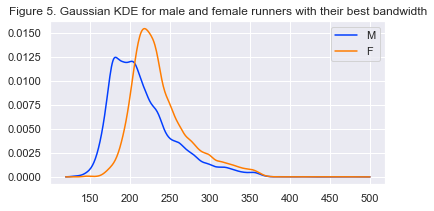

In [14]:
# Compute the density estimates with its best bandwith parameter
kde_m = gaussian_kde(dfm['Total_minutes'], bw_method=best_bw_m)
kde_f = gaussian_kde(dff['Total_minutes'], bw_method=best_bw_f)
# Plotting the best bandwith parameter
plt.figure(figsize=(6, 3))
x = np.linspace(120,500,400)
plt.plot(x, kde_m(x),label='M')
plt.plot(x, kde_f(x),label='F')
plt.title("Figure 5. Gaussian KDE for male and female runners with their best bandwidth")
plt.legend()

### 3.1.3. Bayes Theorem on 1-D KDE

For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. It's still Bayesian classification, but it's no longer naive [3].

By combining KDE with Bayes theorem, we can make predictions about the gender of runners based on their finish times. By considering the likelihood of being male or female for a given finish time, we can classify runners into their respective genders, in this section we will make prediction of marathon participants' gender.

In [15]:
def prob_runtime_female(dfm, dff, kde_m, kde_f, time):
    # Calculate the prior probability for male and female
    prob_m = dfm_train['M/F'].count() / train_df['M/F'].count()
    prob_f = dff_train['M/F'].count() / train_df['M/F'].count()
    # Total probability
    total_P = kde_m(time) * prob_m + kde_f(time) * prob_f 
    # Apply Bayes Theorem to calculate the posterior probability for female 
    posterior_f = kde_f(time) * prob_f / total_P  

    return posterior_f

In [18]:
# Calculate the posterior probability of female in train set
posterior_probs = []
for index, row in train_df.iterrows():
    time = row['Total_minutes']
    time_reshaped = np.array([[time]]).reshape(1, 1)
    posterior_prob = prob_runtime_female(dfm_train, dff_train, kde_m, kde_f, time_reshaped)
    posterior_probs.append(posterior_prob)
    
# Predictions using 2-D KDE and Naive Bayes
predictions = [1 if p > 0.5 else 0 for p in posterior_probs]
actual_labels = train_df['M/F'].map({'M': 0, 'F': 1}).tolist()

# Calculate accuracy
accuracy = sum([1 if p == a else 0 for p, a in zip(predictions, actual_labels)]) / len(predictions)
print("Accuracy for 1-D KDE is :", accuracy)

Accuracy for 1-D KDE is : 0.6531295155525135


In [19]:
# Make prediction on test set
posterior_probs_test = []
for index, row in test_df.iterrows():
    time = row['Total_minutes']
    time_reshaped = np.array([[time]]).reshape(1, 1)
    posterior_prob = prob_runtime_female(dfm_train, dff_train, kde_m, kde_f, time_reshaped)
    posterior_probs_test.append(posterior_prob)

predictions_test = [1 if p > 0.5 else 0 for p in posterior_probs_test]
actual_labels_test = test_df['M/F'].map({'M': 0, 'F': 1}).tolist()

### 3.1.4. Accuracy

In [20]:
accuracy_test = sum([1 if p == a else 0 for p, a in zip(predictions_test, actual_labels_test)]) / len(predictions_test)
print("Accuracy on test set:", accuracy_test)

Accuracy on test set: 0.6571863117870722


The prediction of female runners based on their `Total_minutes` using 1-D KDE and Bayes' theorem yields an accuracy of 0.657 which is relatively successful in classifying the gender of runners based on their total time. By applying Bayes' theorem to calculate the posterior probability of being female, the model is able to make predictions with a relatively high level of accuracy.

However, we can try to do better, may be additional features that can contribute to a more accurate prediction of female runners. We will explore 2-dimensional KDE models with additional features `Age` to see if it potentially enhance the accuracy of our prediction. 

## 3.2. KDE for 2-dimension

  Compute 2-dimensional kernel density estimate (KDE) of male and female runners using finish times and ages of runners, and use it together with the Bayes theorem to compute the probability that a runner with a given time was a female. Use this to make predictions if a runner was a male/female based on their finish times and check accuracy of these predictions.
  
  The two-dimensional kernel density estimation uses the principle of kernel density estimation to plot the density of points on the two-dimensional plane. It is a method to express probability density distribution through pixels. 
In principle, 2-D kernel density estimation is the expansion of 1-D situation. The space of dataset transfer from axis to a plane, so the each data point will have 2 dimention information. We need to choose another value format to describe the density. Consequently the value of pixels can be used to present the density. In 2-D KDE, we use the distance parameter `dist` to replace the single parameter in 1-D dimention.


### 3.2.1. Model Development

In [21]:
kde = gaussian_kde(train_df[['Total_minutes','Age']].T, bw_method = 0.3)
kde([0.5, 0.5])

array([3.82708511e-37])

/var/folders/nv/g99lnjz16bb71bhj2kx_xw4r0000gn/T/ipykernel_57437/3101693015.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Runner age')

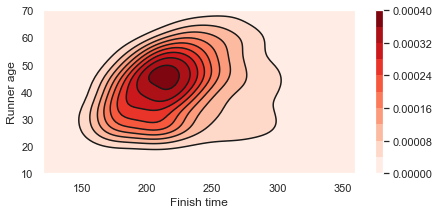

In [22]:
x = np.linspace(120,360,100)
y = np.linspace(10,70,100)
X,Y = np.meshgrid(x,y)
Z = kde([X.reshape(-1),Y.reshape(-1)]).reshape(X.shape)

plt.figure(figsize=(7,3))
plt.contourf(X,Y,Z,levels=10,cmap='Reds')
plt.colorbar()
plt.contour(X,Y,Z,levels=10,colors='k')
plt.xlabel('Finish time')
plt.ylabel('Runner age')

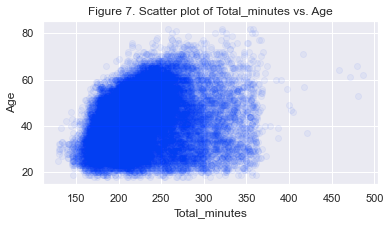

In [23]:
plt.figure(figsize=(6,3))
plt.scatter(df['Total_minutes'],df['Age'],alpha=.05)
plt.xlabel("Total_minutes")
plt.ylabel("Age")
plt.title("Figure 7. Scatter plot of Total_minutes vs. Age")
plt.show()

### 3.2.2. Find the Bandwidth which gives the highest probability 

In [24]:
# List of bandwidth values 
bw_choices_m = []
bw_choices_f = []

for bw in np.linspace(0.01, 0.9, 50):
  # Estimate Gaussian KDE in train set for different bandwidth values 
    kde_m = gaussian_kde(dfm_train[['Total_minutes', 'Age']].T, bw_method=bw)
    kde_f = gaussian_kde(dff_train[['Total_minutes', 'Age']].T, bw_method=bw)
  # Calculate the likelihood in validation data
    log_likelihood_m = np.log(kde_m(dfm_valid[['Total_minutes', 'Age']].T)).sum()
    log_likelihood_f = np.log(kde_f(dff_valid[['Total_minutes', 'Age']].T)).sum()
  # Store bandwidth values and log likelihood in the list
    bw_choices_m.append((bw, log_likelihood_m))
    bw_choices_f.append((bw, log_likelihood_f))

# Convert the lists to NumPy arrays
bw_m = np.array(bw_choices_m)
bw_f = np.array(bw_choices_f)
# Find the maximum log-likelihood values
max_likelihood_m = bw_m[:, 1].max()
max_likelihood_f = bw_f[:, 1].max()
# Find the bandwidth values with the maximum log-likelihood
best_bw_m = bw_m[:, 0][bw_m[:, 1] == max_likelihood_m]
best_bw_f = bw_f[:, 0][bw_f[:, 1] == max_likelihood_f]

# Print the best bandwidth result 
print("The best estimator bandwidth for male is: ", best_bw_m)
print("The best estimator bandwidth for female is: ", best_bw_f)


/var/folders/nv/g99lnjz16bb71bhj2kx_xw4r0000gn/T/ipykernel_57437/327396105.py:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood_m = np.log(kde_m(dfm_valid[['Total_minutes', 'Age']].T)).sum()
/var/folders/nv/g99lnjz16bb71bhj2kx_xw4r0000gn/T/ipykernel_57437/327396105.py:11: RuntimeWarning: divide by zero encountered in log
  log_likelihood_f = np.log(kde_f(dff_valid[['Total_minutes', 'Age']].T)).sum()
/var/folders/nv/g99lnjz16bb71bhj2kx_xw4r0000gn/T/ipykernel_57437/327396105.py:11: RuntimeWarning: divide by zero encountered in log
  log_likelihood_f = np.log(kde_f(dff_valid[['Total_minutes', 'Age']].T)).sum()


The best estimator bandwidth for male is:  [0.15530612]
The best estimator bandwidth for female is:  [0.19163265]


/var/folders/nv/g99lnjz16bb71bhj2kx_xw4r0000gn/T/ipykernel_57437/2475824920.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Density")


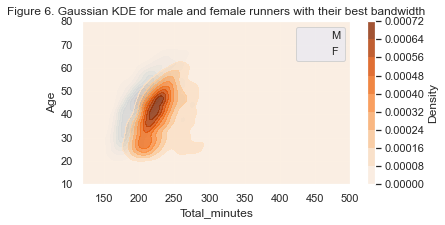

In [25]:
# Estimate Gaussian KDE in train set for different bandwidth values 
kde_m = gaussian_kde(dfm_test[['Total_minutes', 'Age']].T, bw_method=best_bw_m[0])
kde_f = gaussian_kde(dff_test[['Total_minutes', 'Age']].T, bw_method=best_bw_f[0])

# Create a grid of points for evaluation
x, y = np.meshgrid(np.linspace(120, 500, 400), np.linspace(10, 80, 400))
points = np.vstack([x.ravel(), y.ravel()])

# Evaluate the KDE on the grid of points
kde_m_vals = kde_m(points)
kde_f_vals = kde_f(points)

# Reshape the KDE values to match the grid shape
kde_m_vals = kde_m_vals.reshape(x.shape)
kde_f_vals = kde_f_vals.reshape(x.shape)

# Plot the KDEs
plt.figure(figsize=(6, 3))
plt.contourf(x, y, kde_m_vals, cmap='Blues', levels=10, alpha=0.8)
plt.contourf(x, y, kde_f_vals, cmap='Oranges', levels=10, alpha=0.8)
plt.title("Figure 6. Gaussian KDE for male and female runners with their best bandwidth")
plt.xlabel("Total_minutes")
plt.ylabel("Age")
plt.colorbar(label="Density")
plt.legend(['M', 'F'])
plt.show()

Figure 8. gives density distribution across the `Total_minutes` and `Age` variables using the best bandwidth values `best_bw_m` and `best_bw_f` obtained previously.

### 3.2.3. Apply Bayes Theorem with 2-D KDE

In [26]:
def prob_runtime_female(dfm, dff, kde_m, kde_f, time):
    # Calculate the prior probability for male and female
    prob_m = dfm_train['M/F'].count() / train_df['M/F'].count()
    prob_f = dff_train['M/F'].count() / train_df['M/F'].count()
    # Total probability
    total_P = kde_m(time) * prob_m + kde_f(time) * prob_f 
    # Apply Bayes Theorem to calculate the posterior probability for female 
    posterior_f = kde_f(time) * prob_f / total_P  

    return posterior_f

In [27]:
# Calculate the posterior probability of female in train set
posterior_probs = []
for index, row in train_df.iterrows():
    time = row['Total_minutes']
    time_reshaped = np.array([time, row['Age']]).reshape(2, 1)
    posterior_prob = prob_runtime_female(dfm_train, dff_train, kde_m, kde_f, time_reshaped)
    posterior_probs.append(posterior_prob)
    
# Predictions using 2-D KDE and Naive Bayes
predictions = [1 if p > 0.5 else 0 for p in posterior_probs]
actual_labels = train_df['M/F'].map({'M': 0, 'F': 1}).tolist()

# Calculate accuracy
accuracy = sum([1 if p == a else 0 for p, a in zip(predictions, actual_labels)]) / len(predictions)
print("Accuracy for 2-D KDE is :", accuracy)

Accuracy for 2-D KDE is : 0.7573199482850407


In [28]:
# Make prediction on test set
posterior_probs_test = []
for index, row in test_df.iterrows():
    time = row['Total_minutes']
    time_reshaped = np.array([time, row['Age']]).reshape(2, 1)
    posterior_prob = prob_runtime_female(dfm_train, dff_train, kde_m, kde_f, time_reshaped)
    posterior_probs_test.append(posterior_prob)

predictions_test = [1 if p > 0.5 else 0 for p in posterior_probs_test]
actual_labels_test = test_df['M/F'].map({'M': 0, 'F': 1}).tolist()

### 3.2.4. Acurracy

In [29]:
accuracy_test = sum([1 if p == a else 0 for p, a in zip(predictions_test, actual_labels_test)]) / len(predictions_test)
print("Accuracy on test set:", accuracy_test)

Accuracy on test set: 0.7747528517110266


The accuracy of 0.775 obtained using 2-D KDE for predicting female runners in the marathon dataset is higher compared to previous 1-dimensional KDE model. 2-D KDE achieved significant improvement on prediction the female runners on their `Total_minutes` and `Age`. I think because we trained the KDE with more input features, so it takes into account the relationship between these variables better. Therefore, we may want to compare our KDE models with other classifier such as KNN to see which algorithms work better to predict female runners based on the same features. 

# 4. Comparision KDE with KNN models:
  In this section, we first train our data with KNN models then compare accuracy of predictions obtained from 1-D KDE and 2-D KDE in parts 1 and 2 to the predictions made using k- NN with the same input data.

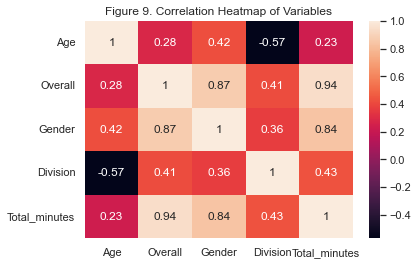

In [30]:
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.title("Figure 9. Correlation Heatmap of Variables")
plt.show()

From Figure 9. the relationship between `Gender` and `Age` / `Total_minutes` / `Overall` gives a high correlation. So, we will train our first KNN with `Total_minutes` to predict the sex of runners. Next, we will train our second KNN with both `Age` and `Total_minutes` to see if these features impressive improve the accurate prediction for gender of runners. 

## 4.1. KNN with the `Total_minutes` feature

In [31]:
k=5
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_df[['Total_minutes']],train_df['M/F'])
knn_pred = neigh.predict(test_df[['Total_minutes']])
knn_pred

array(['F', 'F', 'M', ..., 'F', 'M', 'M'], dtype=object)

Let's performs a grid search with cross-validation to find the best value of k (number of neighbors) for k-nearest neighbors classifier that inputs `Total_minutes`. 

In [32]:
# Define the param for grid search
parameters = {'n_neighbors': range(1, 100)}

# Create an instance of the k-NN regressor
knn = KNeighborsClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=5) # 5-fold cross-validation
grid_search.fit(valid_df[['Total_minutes']], valid_df['M/F'])

# Print the best parameter value and corresponding mean cross-validated score
print("Best value of k: ", grid_search.best_params_['n_neighbors'])
print("Best mean cross-validated score: ", grid_search.best_score_)

Best value of k:  75
Best mean cross-validated score:  0.6466408551371309


The `best_score_` attribute of the GridSearchCV object stores the average score (e.g., accuracy, precision, recall) obtained by the model during cross-validation using the best combination of hyperparameters. It represents the performance estimate of the model on unseen data based on the selected hyperparameters [3].

The KNN model with the best value of $k$ ($k$=75) achieved a mean cross-validated score of approximately 0.647. This means that during the grid search process, the KNN model with $k$=75 performed the best among the different values of $k$ tested. The mean cross-validated score of 0.647 indicates the average performance of the model across multiple folds during cross-validation.

In this case, the KNN model with k=75 achieved a relatively moderate level of performance. 

In [33]:
best_n_neighbors = grid_search.best_params_['n_neighbors']
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh.fit(train_df[['Total_minutes']], train_df['M/F'])
knn_pred = neigh.predict(test_df[['Total_minutes']])

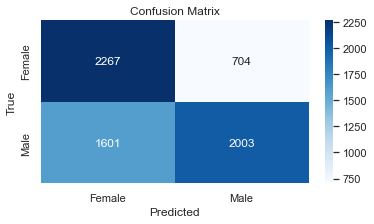

The accuracy of KNN with the best n_neighbors is: 0.65


In [34]:
cm = confusion_matrix(test_df['M/F'], knn_pred)
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 3))
ax = plt.gca()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Female', 'Male'])
ax.yaxis.set_ticklabels(['Female', 'Male'])
plt.show()

# Print out the accuracy of KNN model
knn_accuracy = accuracy_score(test_df['M/F'], knn_pred)
print("The accuracy of KNN with the best n_neighbors is: {:.2f}".format(knn_accuracy))

Compared with 1-D KDE model with the same input feature (accuracy = 0.6571863117870722), KNN with the best n_neighbors give similar accuracy of 0.65.

## 4.2. KNN with the `Total_minutes` and `Age` features

In [35]:
k=5
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_df[['Total_minutes', 'Age']],train_df['M/F'])
knn_pred = neigh.predict(test_df[['Total_minutes', 'Age']])
knn_pred

array(['F', 'F', 'M', ..., 'M', 'M', 'F'], dtype=object)

In [36]:
# Define the param for grid search
parameters = {'n_neighbors': range(1, 100)}

# Create an instance of the k-NN regressor
knn = KNeighborsClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=5) # 5-fold cross-validation
grid_search.fit(valid_df[['Total_minutes', 'Age']], valid_df['M/F'])

# Print the best parameter value and corresponding mean cross-validated score
print("Best value of k: ", grid_search.best_params_['n_neighbors'])
print("Best mean cross-validated score: ", grid_search.best_score_)

Best value of k:  99
Best mean cross-validated score:  0.7582897257380303


The KNN model with the best value of `n_neighbors` ($k$=99) achieved a relatively high mean cross-validated score of 0.758, indicating its strong performance in predicting the gender of runners based on the features of `Total_minutes` and `Age`. Using additional features `Age` demonstrates better predictive performace in determining the gender of runners. 

In [37]:
best_n_neighbors = grid_search.best_params_['n_neighbors']
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors)
neigh.fit(train_df[['Total_minutes', 'Age']], train_df['M/F'])
knn_pred = neigh.predict(test_df[['Total_minutes', 'Age']])

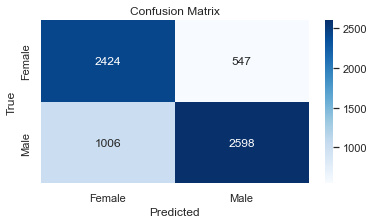

The accuracy of KNN with the best n_neighbors is: 0.76


In [38]:
cm = confusion_matrix(test_df['M/F'], knn_pred)
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 3))
ax = plt.gca()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Female', 'Male'])
ax.yaxis.set_ticklabels(['Female', 'Male'])
plt.show()

# Print out the accuracy of KNN model
knn_accuracy = accuracy_score(test_df['M/F'], knn_pred)
print("The accuracy of KNN with the best n_neighbors is: {:.2f}".format(knn_accuracy))

In [39]:
# Calculate precision, recall, and F1 score
classifier_report = classification_report(test_df['M/F'], knn_pred)
print(classifier_report)

              precision    recall  f1-score   support

           F       0.71      0.82      0.76      2971
           M       0.83      0.72      0.77      3604

    accuracy                           0.76      6575
   macro avg       0.77      0.77      0.76      6575
weighted avg       0.77      0.76      0.76      6575



From classification report of the KNN's performance in predicting the gender of runners based on the features of `Total_minutes` and `Age`, we can conclude that:

* Precision: The model achieved a precision of 0.71 for `F` and 0.83 for `M`, therefore, only 71% of the predicted females and 83% of the predicted males were correctly classified.
* Recall of 0.82 for `F`  and 0.72 for `M`, so that 82% of the actual females and 72% of the actual males were correctly classified.
* F1-score: The F1-score combines precision and recall into a single metric. The F1-score for class `F` is 0.76 and for `M` is 0.77.


When we use additional features for training, the second KNN model with the best value of `n_neighbors` ($k$=99) achieved an accuracy of 0.76, indicating its performance in predicting the gender of runners based on the features of `Total_minutes` and `Age` is significant improved.

### Observation for KNN vs KDE:

Indeed, the accuracy of the K-Nearest Neighbors model based on `Age` and `Total_minutes` with an accuracy of 0.76 is comparable to the accuracy of the 2-D KDE model with an accuracy of 0.774. While the difference in accuracy is relatively small, it's important to consider that these models might excel in different aspects.

As the 2-D KDE model estimates the probability density function based on the given data and uses Bayes' theorem to calculate the posterior probability. It captures the joint distribution of `Age` and `Total_minutes` and provides a density estimation. Although both models achieve similar accuracies, but 2-D KDE model has the advantage of capturing the underlying distribution of the data and can potentially provide more nuanced insights. In the another study, we may explore how to tune the 2-D KDE model and to see if it enhances predictive performance.


# 5. Linear Regression to Predict Finish Time:

In this final section, we will use linear regression to predict finish times of runners.

First, we need to convert `5K` into duration in minutes:

In [40]:
# Convert the '5K' column to timedelta objects and then calculate the total duration in minutes.
train_df['5K'] = pd.to_timedelta(train_df['5K']).dt.total_seconds() / 60
test_df['5K'] = pd.to_timedelta(test_df['5K']).dt.total_seconds() / 60

train_df.head()

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,Total_minutes
1024,33,M,USA,18.550000,00:37:18,00:56:26,01:15:51,01:20:12,01:35:51,01:56:38,02:18:35,02:40:36,02:50:47,00:06:31,1026,985,825,170.783333
14892,40,F,USA,26.733333,00:53:34,01:20:44,01:47:42,01:53:30,02:14:47,02:42:09,03:09:04,03:34:16,03:45:06,00:08:36,14970,5196,914,225.100000
13216,55,M,USA,25.233333,00:49:51,01:14:52,01:41:52,01:47:19,02:07:11,02:33:40,03:01:24,03:27:57,03:39:35,00:08:23,13277,9100,653,219.583333
10302,37,M,USA,26.283333,00:50:37,01:15:09,01:40:43,01:46:17,02:07:12,02:33:12,02:57:48,03:21:09,03:30:35,00:08:02,10337,7833,3560,210.583333
13164,57,M,USA,25.300000,00:49:50,01:14:45,01:39:49,01:45:22,02:05:06,02:31:41,02:59:42,03:27:39,03:39:26,00:08:23,13224,9080,647,219.433333


## 5.1. Linear Regression based on 5K times

 We base on runners `5K` times for feature input.

In [41]:
# Model training
lr = LinearRegression()
lr.fit(train_df[['5K']], train_df['Total_minutes'])
lr_pred = lr.predict(test_df[['5K']])

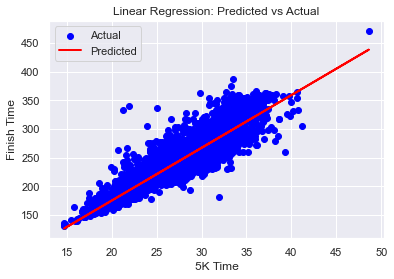

In [42]:
# Plotting the linear line
plt.scatter(test_df['5K'], test_df['Total_minutes'], color='blue', label='Actual')
plt.plot(test_df['5K'], lr_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('5K Time')
plt.ylabel('Finish Time')
plt.legend()
plt.title('Linear Regression: Predicted vs Actual')
plt.show()


In [43]:
# # Evaluaion metric for linear regression
mse = mean_squared_error(test_df['Total_minutes'], lr_pred)
print("Mean squared error: %.2f" % mse)
print("Root mean squared error (RMSE): %.2f" % np.sqrt(mse))
print("Coefficient of determination: %.2f" % r2_score(test_df['Total_minutes'], lr_pred))
print("Coefficients: %.2f" % lr.coef_)

Mean squared error: 244.60
Root mean squared error (RMSE): 15.64
Coefficient of determination: 0.85
Coefficients: 9.20


For linear model, we don't use accuracy as metric evaluation, instead, computing `Mean squared error` which measures the average squared difference between the predicted finish times and the actual finish time of runners, and `Root mean squared error` which is the square root of MSE. 

Our MSE for linear regression using only `5K` as feature input is 244.60 which indicates that the deviation to actual finish times is 244.60. The coefficient of determination, also known as R-squared, measures the proportion of the variance in the finish times that can be explained by the linear regression model. And our value of 0.85 indicates that the model accounts for approximately 85% of the variability in the finish times based on the `5K` feature alone, suggesting that the `5K` feature is a strong predictor of the finish times. The coefficient of 9.20 is the slope of the linear regression line for the `5K` feature. This positive coefficient shows that faster `5K` time is associated with a faster finish time.

## 5.2. Linear Regression with combination of features

We continue building another linear regression model that uses other data `Age` and `M/F` together with the `5K` times to predict finish times, and check if this meaningfully improves the predictions.

In [44]:
# Scale numeric features '5K' and 'Age'
scaler = StandardScaler()
train_df[['5K', 'Age']] = scaler.fit_transform(train_df[['5K', 'Age']])
test_df[['5K', 'Age']] = scaler.transform(test_df[['5K', 'Age']])

# One-hot encode the categorical feature
encoder = OneHotEncoder(sparse=False)
train_encoded = encoder.fit_transform(train_df[['M/F']])
test_encoded = encoder.transform(test_df[['M/F']])

# Combine the encoded categorical feature with the scaled numeric features
train_scaled = np.hstack((train_encoded, train_df[['5K', 'Age']]))
test_scaled = np.hstack((test_encoded, test_df[['5K', 'Age']]))

# Predictions using linear regression
lr = LinearRegression()
lr.fit(train_scaled, train_df['Total_minutes'])
lr_pred = lr.predict(test_scaled)

# Evaluaion metric for linear regression
mse = mean_squared_error(test_df['Total_minutes'], lr_pred)
print("Mean squared error: %.2f" % mse)
print("Root Mean Squared Error (RMSE): %.2f" % np.sqrt(mse))
print("Coefficient of determination: %.2f" % r2_score(test_df['Total_minutes'], lr_pred))
print("Coefficients:")
for feature, coefficient in zip(train_df.columns, lr.coef_):
    print(f"{feature}: {coefficient:.2f}")


Mean squared error: 240.73
Root Mean Squared Error (RMSE): 15.52
Coefficient of determination: 0.85
Coefficients:
Age: 0.08
M/F: -0.08
Country: 36.55
5K: 2.02


The coefficients represent the estimated impact of each feature on the target variable `Total_minutes`. In this case, our coefficients for this linear regression model are: 


`5K`: 2.02 has a positive impact on `Total_minutes`.

`Age`: 0.08 has a positive impact on `Total_minutes`.

`M/F`: has a positive impact on `Total_minutes`.


Compare to `MSE` from previous model using only one feature input, 240.73 is smaller compared to 244.60. 
    Both models have similar `RMSE` values, our model with 3 feature inputs having a slightly lower value of 15.52 compared to model using `5K` feature  with 15.64, I think model 2 performs slightly better. Both models have the same R-squared value of 0.85, likely, both models can explain approximately 85% of the variance in the target variable `Total_minutes`.


# 6. Conclusion:

Although we have explored several models such as 1D Kernel Density Estimation (KDE), 2D KDE, K-Nearest Neighbors (KNN), and Linear Regression for gender prediction in the marathon dataset, there are still potential areas for further investigation and improvement. For future direction, we can use linear regression model from PyTorch which enables the advanced capabilities for building and training neural networks. This might be an improvement on complex relationships within `marathon_result` dataset. Additionally, I think using additional features such as `Country` and `Pace` for training can provide more information for the models. Example, `Pace` reflects velocity differences between `M/F`, so potentially contribute to higher accurate prediction. 

# 7. Appendix:

[1] Kernel density estimation | Cartography Playground. (n.d.). Cartography-Playground.gitlab.io. Retrieved May 14, 2023, from https://cartography-playground.gitlab.io/playgrounds/kernel-density-estimation/


[2] Wikipedia Contributors. (2019, September 11). Kernel density estimation. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Kernel_density_estimation


[3] Shah, R. (2021, June 23). GridSearchCV |Tune Hyperparameters with GridSearchCV. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/


[4] Code was adopted from class lecture week 14